## Outline

1. Import plda and other convenient packages.
2. Load data.
3. Preprocess data and fit model.
4. __How to classify datapoints: Overfit classifier__.
5. __How to classify datapoints: Better-fit classifier__.
6. Extracting LDA-features.
7. __How to classify datapoints: "same-or-different category" discrimination__.
8. Extracting preprocessing information.
9. Extracting model parameters.

## Import plda and other convenient packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plda

%matplotlib inline

## Load Data.

In [2]:
# To minimize the size of this repository, I only provide 200 training and 100 testing images.
training_data = np.load('mnist_data/mnist_train_images.npy')
training_labels = np.load('mnist_data/mnist_train_labels.npy')
testing_data = np.load('mnist_data/mnist_test_images.npy')
testing_labels = np.load('mnist_data/mnist_test_labels.npy')

In [3]:
print(training_data.shape, training_labels.shape)
print(testing_data.shape, testing_labels.shape)

(200, 784) (200,)
(100, 784) (100,)


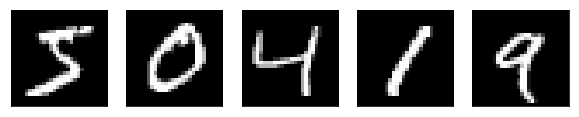

In [4]:
n_examples = 5
fig, ax_arr = plt.subplots(1, n_examples, figsize=(10, 2))

for x in range(n_examples):
    ax_arr[x].imshow(training_data[x].reshape(28, 28), cmap='gray')
    ax_arr[x].set_xticks([])
    ax_arr[x].set_yticks([])
plt.show()

## Preprocess data and fit model.

You have 3 options.

1. Default: keep as many principal components as possible (i.e. overfit). See `plda.Model.fit()`) for details.
2. Optional: specify a smaller number of desired principal components to use (potentially reduces overfitting).
3. Alternatively, you can preprocess the data yourself before passing it to this model.

__Fit model for overfit classifier__ (default)

In [5]:
# Use as many principal components in the data as possible.

overfit_classifier = plda.Classifier()
overfit_classifier.fit_model(training_data, training_labels)

__Fit model for better fit classifier__ (optional)

In [6]:
# Use the 5 top principal components to reduce overfitting.
# This will preprocess training data from shape (200, 784) to (200, 5).

better_classifier = plda.Classifier()
better_classifier.fit_model(training_data, training_labels, n_principal_components=5)

## How to classify datapoints: Overfit classifier.

In [7]:
predictions, log_p_predictions = overfit_classifier.predict(testing_data)

# Overfit:
#  Ratio of avg. sample size to data dimension is very small
#  (about ~20 / 200 = ~.2).
print('Accuracy: {}'.format((testing_labels == predictions).mean()))

Accuracy: 0.28


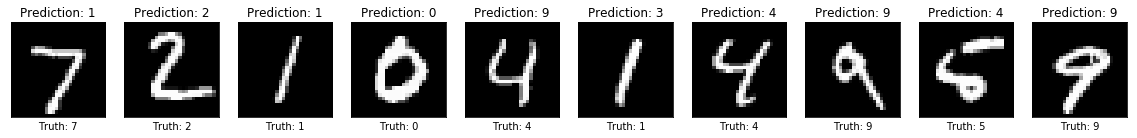

In [8]:
n_examples = 10
fig, ax_arr = plt.subplots(1, n_examples, figsize=(20, 2))

for x in range(n_examples):
    ax_arr[x].imshow(testing_data[x].reshape(28, 28), cmap='gray')
    ax_arr[x].set_xticks([])
    ax_arr[x].set_yticks([])
    title = 'Prediction: {}'
    xlabel = 'Truth: {}'
    ax_arr[x].set_title(title.format(predictions[x]))
    ax_arr[x].set_xlabel(xlabel.format(testing_labels[x]))
plt.show()

## How to classify datapoints: Better-fit classifier.

In [9]:
predictions, log_p_predictions = better_classifier.predict(testing_data)
print('Accuracy: {}'.format((testing_labels == predictions).mean()))

Accuracy: 0.54


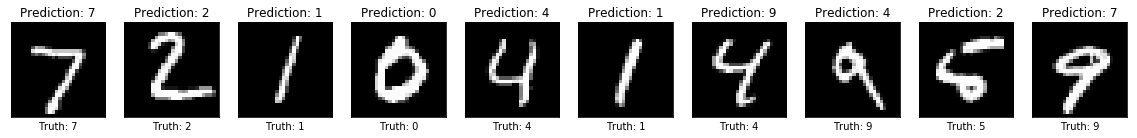

In [10]:
n_examples = 10
fig, ax_arr = plt.subplots(1, n_examples, figsize=(20, 2))

for x in range(n_examples):
    ax_arr[x].imshow(testing_data[x].reshape(28, 28), cmap='gray')
    ax_arr[x].set_xticks([])
    ax_arr[x].set_yticks([])
    title = 'Prediction: {}'
    xlabel = 'Truth: {}'
    ax_arr[x].set_title(title.format(predictions[x]))
    ax_arr[x].set_xlabel(xlabel.format(testing_labels[x]))
plt.show()

## Retrieving N best predictions
You may need to get n best predictions of you test set. In this case you can use `n_best` parameter in `predict` method. In bellow example we'll show a use of this parameter.

In [11]:
def if_predicted(query, predicted):
    if isinstance(predicted, (int, np.uint8)):
        return query == predicted
    return True if query in predicted else False

In [12]:
predictions, log_p_predictions = better_classifier.predict(testing_data, n_best=3)
print('Accuracy@2: {}'.format(np.array(list(map(if_predicted, testing_labels, predictions))).mean()))

Accuracy@2: 0.87


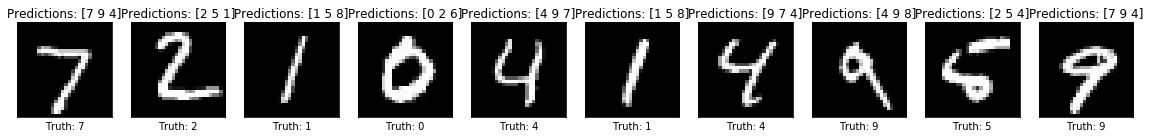

In [13]:
n_examples = 10
fig, ax_arr = plt.subplots(1, n_examples, figsize=(20, 2))

for x in range(n_examples):
    ax_arr[x].imshow(testing_data[x].reshape(28, 28), cmap='gray')
    ax_arr[x].set_xticks([])
    ax_arr[x].set_yticks([])
    title = 'Predictions: {}'
    xlabel = 'Truth: {}'
    ax_arr[x].set_title(title.format(predictions[x]))
    ax_arr[x].set_xlabel(xlabel.format(testing_labels[x]))
plt.show()

As you can see some truth classes are found in second predictions.

## Extracting LDA features.
There are 4 "spaces" that result from the transformations the model performs:
1. Data space ('D'),
2. Preprocessed data space ('X'),
3. Latent space ('U'), and
4. The "effective" space of the latent space ('U_model'), 
    which is essentially the set of dimensions the model actually uses for prediction.

You can transform data between these spaces using the `classifier.model.transform()` function.

In [14]:
U_model = better_classifier.model.transform(training_data, from_space='D', to_space='U_model')

print(training_data.shape)
print(U_model.shape)

(200, 784)
(200, 5)


In [15]:
D = better_classifier.model.transform(U_model, from_space='U_model', to_space='D')

print(U_model.shape)
print(D.shape)

(200, 5)
(200, 784)


## How to classify datapoints: same-different discrimination.

These are log-ratios, which means:
- negative values mean that the model believes the two data points being compared are from two different categories.
- positive values mean that the model believes the two data points are from the same category.

In [16]:
U_datum_0 = U_model[0][None,]
U_datum_1 = U_model[1][None,]

log_ratio_0_1 = better_classifier.model.calc_same_diff_log_likelihood_ratio(U_datum_0, U_datum_1)

print(log_ratio_0_1)

-4.790802038361864


In [17]:
U_datum_2 = U_model[2][None,]
U_datum_5 = U_model[5][None,]

log_ratio_2_5 = better_classifier.model.calc_same_diff_log_likelihood_ratio(U_datum_2, U_datum_5)

print(log_ratio_2_5)

1.0497728344454718


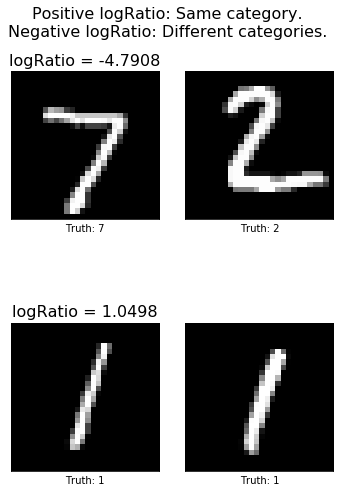

In [18]:
n_examples = 4
fig, ax_arr = plt.subplots(int(n_examples / 2), 2, figsize=(5, 7.5))

for x, ax in enumerate(ax_arr.flat):
    ax.imshow(testing_data[[0, 1, 2, 5]][x].reshape(28, 28), cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    xlabel = 'Truth: {}'
    ax.set_xlabel(xlabel.format(testing_labels[[0, 1, 2, 5]][x]))
    
ax_arr[0, 0].set_title("logRatio = {}".format(round(log_ratio_0_1, 4)),
                        fontsize=16)
ax_arr[1, 0].set_title("logRatio = {}".format(round(log_ratio_2_5, 4)),
                        fontsize=16)

fig.suptitle("Positive logRatio: Same category.\nNegative logRatio: Different categories.",
             x=.5, y=.99, fontsize=16)

fig.tight_layout()

## Getting PCA Preprocessing information

In [19]:
type(better_classifier.model.pca)  # Check out the sklean documentation.

sklearn.decomposition._pca.PCA

In [20]:
better_classifier.model.pca

PCA(n_components=5)

In [21]:
better_classifier.model.pca.n_features_  # Original dimensionality.

784

In [22]:
better_classifier.model.pca.n_components  # Preprocessed dimensionality

5

## Parameters fitted via Empirical Bayes.
This is like maximum likelihood estimation in that you are estimating the parameters of your prior using data. Yes, I know this bugs a lot of statisticians, lol.

In [23]:
Psi = better_classifier.model.Psi
A = better_classifier.model.A
inv_A = better_classifier.model.inv_A
m = better_classifier.model.m

# Indices of the subspace used for classification.
relevant_U_dims = better_classifier.model.relevant_U_dims

__Prior__.

In [24]:
better_classifier.model.prior_params.keys()

dict_keys(['mean', 'cov_diag'])

__Posterior__

In [25]:
better_classifier.model.posterior_params.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [26]:
# Posterior parameters for a category.
better_classifier.model.posterior_params[0].keys()

dict_keys(['mean', 'cov_diag'])

__Posterior Predictive__

In [27]:
# Categories in the training data.
better_classifier.model.posterior_predictive_params.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [28]:
# Parameters for a category.
better_classifier.model.posterior_predictive_params[0].keys()

dict_keys(['mean', 'cov_diag'])